# 3.Data Preprocessing

*Made by David Serrano for his Final Bachelor Thesis*


This file creates several important functions to preprocess both the detections and images from the sequences.

## 3.1. Environment Preparation

In [ ]:
# Useful general imports
from google.colab import drive 

In [ ]:
# mount the google drive folder to access to all the files in there
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Add the folder called utils that has all the custom modules in .py files
import sys
sys.path.append('/content/drive/MyDrive/TFG/utils')

In [ ]:
from paths import PROJECT_ROOT, HDF5_FOLDER, JSON_FOLDER, USABLE_SEQUENCES, MAX_SQUARE_LEN

## 3.2. Loaders

In the following block, a function which is capable of initializing  multiple **hdf5Loaders** is defined.

The class **hdf5Loaders** initialize a sequence file without loading the whole sequence. Then, with some functions we have the possibilty of acquiring a specific frame or other useful information as the number of frames of the entire video.

This is very useful to avoid using large quantities of memory at the same

In [ ]:
# INITIALIZE ALL THE HDF5LOADERS
from hdf5Loader import hdf5Loader

def hdf5Initializer(hdf5Names):
    """
    Function to load all the sequence loaders
    :param hdf5Names: list with all the filenames
    :return: list with all de hdf5Loaders
    """
    loaders = []
    for n in hdf5Names:
        loaders.append(hdf5Loader(HDF5_FOLDER + n + '.h5'))

    return loaders

In the following block, a function which is capable of initializing detections is defined. It has two options:


*   *tracks = True*: load all the detections of the list of sequences passed as paramater
*   *tracks = False*: load one detections for each track of the list. Take the frame in the center of the track as the thumbnail

The function loads the detections, but it also adds 2 positions. The first one called sequence number, in the position 0, to identify from which sequence the detection is. And the second one called repetition number, in the last position, to identify which repetition of the track is. The last addition will be useful when doing data augmentation or dataset balancing. When loading the detections directly from the json files the repettiton number is always 0 since there is no track repetitions.


In [ ]:
# INITIALIZE ALL THE DETECTIONS AS:
# [seqNum, frameNum, trackID, xmin, ymin, xmax, ymax, label]
import math
from JSONLoader import loadData

def detectionLoader(jsonNamesList, tracks=False):
    """
    Function to load detections which are in .json files
    :param jsonNamesList: list with all the filenames
    :param tracks:
        if False:   load all the detections
        if True:    load only one detections for each track. Take as the 
                    thumbnail the frame of the middle of the track
    :return: detection list
    :return: label list with the same order of the detection list
    """
    detections = []
    labels = []

    # FRAME BY FRAME DETECTIONS
    # Add all the detectons of the file
    if not tracks:
        for seq in jsonNamesList:
            detections_i = loadData(JSON_FOLDER + seq + '.h5.json')
            seqNum = seq2num(seq)
            for d in detections_i:
                detections.append([seqNum, d[0], d[1], d[2], d[3], d[4], d[5]], 0)
                labels.append(d[6])

    # TRACK DETECTIONS
    # Add one detection per track (the middle one)
    else:
        for seq in jsonNamesList:

            # Detections of each sequence of the list
            detections_i = loadData(JSON_FOLDER + seq + '.h5.json')
            # Number of the sequence
            seqNum = seq2num(seq)

            # List with all the detections with the same trackID            
            sameTrackID_detections = []
            trackID = 0

            for d in detections_i:
                if d[1] == trackID:
                    sameTrackID_detections.append(d)
                else:
                    detections.append([seqNum,
                                sameTrackID_detections[(round(len(sameTrackID_detections)/2))][0],
                                sameTrackID_detections[(round(len(sameTrackID_detections)/2))][1],
                                sameTrackID_detections[(round(len(sameTrackID_detections)/2))][2],
                                sameTrackID_detections[(round(len(sameTrackID_detections)/2))][3],
                                sameTrackID_detections[(round(len(sameTrackID_detections)/2))][4],
                                sameTrackID_detections[(round(len(sameTrackID_detections)/2))][5],
                                0])
                    
                    labels.append(sameTrackID_detections[(round(len(sameTrackID_detections)/2))][6])
                    trackID = d[1]
                    sameTrackID_detections = []
                    sameTrackID_detections.append(d)

            # Add the final track detection
            detections.append([seqNum,
                        sameTrackID_detections[(round(len(sameTrackID_detections)/2))][0],
                        sameTrackID_detections[(round(len(sameTrackID_detections)/2))][1],
                        sameTrackID_detections[(round(len(sameTrackID_detections)/2))][2],
                        sameTrackID_detections[(round(len(sameTrackID_detections)/2))][3],
                        sameTrackID_detections[(round(len(sameTrackID_detections)/2))][4],
                        sameTrackID_detections[(round(len(sameTrackID_detections)/2))][5],
                        0])
            
            labels.append(sameTrackID_detections[(round(len(sameTrackID_detections)/2))][6])
            trackID = d[1]
            sameTrackID_detections = []
            sameTrackID_detections.append(d)
    
    return detections, labels

## 3.3. Auxiliar Functions

In the following block, a function which is capable of taking *n* equidistant detections of all the track detections passed as parameter is defined. 


In [ ]:
import math

def sampleTrackDetections(trackDetections, n):
    """
    Function capable of taking n equidistant frames from the entire track 
    detections
    :param trackDetections: list with only the detections of one track
    :param n: number of frames to take
    :return: list of detectons with len: n
    """
    # Distance between samples
    delta = len(trackDetections) / (n-1)
    
    sample_detections = []

    for i in range(n):
        # Obtain the frameNum of the nth sample
        fNum = math.floor(delta*i)

        # If the last sample exceeds the list limits, reduce one
        if fNum == len(trackDetections):
            fNum = fNum - 1
        sample_detections.append(trackDetections[fNum])
    
    return sample_detections

In the following block, an auxiliar function which is capable of counting and printing the number of labels of the list passed as a parameter.

In [ ]:
def labelCounter(labels):
    """
    Function capable of counting and printing the labels
    :param labels: list of labels
    """
    count_NHS = 0
    count_HS = 0
    count_AN = 0
    for l in labels:
        if l == 0:
            count_NHS = count_NHS + 1
        elif l == 1:
            count_HS = count_HS + 1
        elif l == 2:
            count_AN = count_AN + 1
    
    print('NHS: {}'.format(count_NHS))
    print('HS: {}'.format(count_HS))
    print('AN: {}'.format(count_AN))
    print('TOTAL: {}'.format(count_NHS + count_HS + count_AN))

In the following block, an auxiliar function which is capable of acquiring all the sequence numbers and trackIDs of the detections passed as a parameter.

In [ ]:
def trackLoader(detections):
    """
    :param detections: all the detections
        [seqNum, frameNum, trackID, xmin, ymin, xmax, ymax]
    :return: list of all the trackIDs [seqNum, trackID] 
    """
    trackIDs = []
    for d in detections:
        if not [d[0], d[2], d[7]] in trackIDs:
            trackIDs.append([d[0], d[2], d[7]])

    return trackIDs

In the following block, a function which is capable of cropping the Bounding Boxes into an squared image of **MAX_SQUARE_LEN** x **MAX_SQUARE_LEN**

From having the sequence loader and the detection with its Bounding Box, this function crops the Bounding Box with a square of the maximum length of the BBox. Then resizes the square to another square of **MAX_SQUARE_LEN** x **MAX_SQUARE_LEN**

In [ ]:
import cv2

def crop_detection(image, detection):
    """
    Function to crop the detection in a square of the max length side and then
    resize it to a square MAX_SQUARE_LEN x MAX_SQUARE_LEN"
    :param image: frame of the sequenc > np.ndarray(1024, 1280)
    :param detection: Bounding Box of the detection > [xmin, ymin, xmax, ymax]
    :return: squared image np.ndarray(MAX_SQUARE_LEN, MAX_SQUARE_LEN)
    """
    
    # Find the min point of the square detection
    x_diff = detection[2] - detection[0]
    y_diff = detection[3] - detection[1]
    max_len = max(x_diff, y_diff)
    xmin = ((x_diff - max_len) / 2) + detection[0]
    ymin = ((y_diff - max_len) / 2) + detection[1]

    # If image limits exceeded
    if xmin < 0:
        xmin = 0
    if ymin < 0:
        ymin = 0
    if (xmin + max_len) > image.shape[1]:
        xmin = image.shape[1] - max_len
    if (ymin + max_len) > image.shape[0]:
        ymin = image.shape[0] - max_len

    xmin = int(xmin)
    ymin = int(ymin)
    max_len = int(max_len)
    # Crop and resize the image
    crop_image = image[ymin:(ymin+max_len), xmin:(xmin+max_len)]
    resized_image = cv2.resize(crop_image, (MAX_SQUARE_LEN, MAX_SQUARE_LEN), interpolation=cv2.INTER_NEAREST)
    
    return resized_image

So to show how the function *crop_detection()* works, in the following block one random detection of each label is taken and applied to the funciton in question.

In the first column of the graph, the original image can be seen, whereas in the second one the cropped detection of size **MAX_SQUARE_LEN** x **MAX_SQUARE_LEN** is shown. In all the images, the Bounding Box is visible to create a perception of the dimensionality.

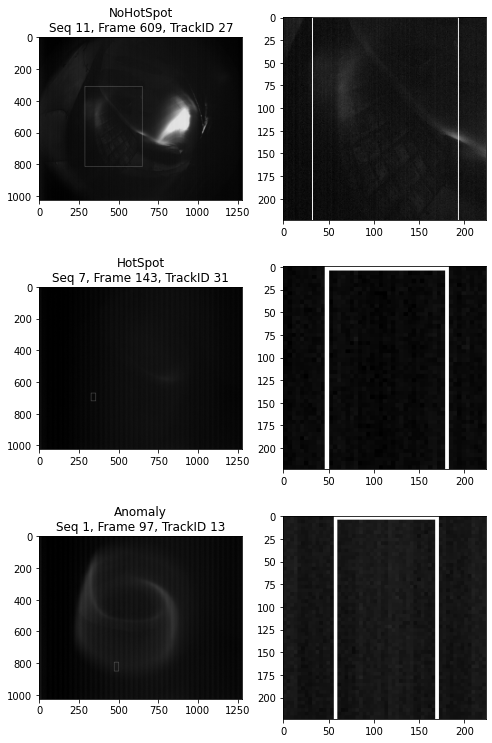

In [ ]:
# Custom imports
from hdf5Loader import hdf5Loader
from image_tools import plotBBoxes, rescaleImage
from sequenceLinker import seq2num, num2seq

import random
import matplotlib.pyplot as plt

# Get the 6 random files
# Change the seed to get other detections
random.seed(42)
NHS = random.randint(0, 873)
HS = random.randint(0, 41)		
AN = random.randint(0, 37)

# Load all the track detections
detections, labels = detectionLoader(USABLE_SEQUENCES, tracks=True)
NHS_counter = 0
HS_counter = 0
AN_counter = 0

# List in which the three detections are stored
# 0: NoHotSpot
# 1: HotSpot
# 2: Anomaly
d3 = [None] * 3

# Obtain the random detections
for (detection, label) in zip(detections, labels):
    if label == 0:
        NHS_counter = NHS_counter + 1
    elif label == 1:
        HS_counter = HS_counter + 1
    elif label == 2:
        AN_counter = AN_counter + 1

    if NHS_counter == NHS:
        d3[0] = detection
    if HS_counter == HS:
        d3[1] = detection
    if AN_counter == AN:
        d3[2] = detection


# Obtain the filenames of the random detections
files2Load = [num2seq(d3[0][0]), num2seq(d3[1][0]), num2seq(d3[2][0])]
# Obtain the hdf5Loaders of the previous sequences
loaders = hdf5Initializer(files2Load)

# 1. Obtain the original images of the sequences
# 2. Rescale the dynamic range to be able to visualize them
# 3. Draw the BBoxes of the detections in the origianl images
OGims = []
for (loader, detection) in zip(loaders, d3):
    im_t = loader.loadImage(detection[0])

    im_t = rescaleImage(im_t)

    detection = [detection[3:7]]
    im_t = plotBBoxes(im_t, detection)

    OGims.append(im_t)

# Obtain the cropped images
cropped_ims = []
for (image, detection) in zip(OGims, d3):
    BBox = detection[3:7]
    cropped_ims.append(crop_detection(image, BBox))

# Plot images
f, axarr = plt.subplots(nrows=3, ncols=2, figsize=(8,13))
titles = ['NoHotSpot\nSeq {}, Frame {}, TrackID {}',
          'HotSpot\nSeq {}, Frame {}, TrackID {}',
          'Anomaly\nSeq {}, Frame {}, TrackID {}']

for i in range(len(cropped_ims)):
        axarr[i,0].imshow(OGims[i])
        axarr[i,1].imshow(cropped_ims[i])
        axarr[i,0].title.set_text(titles[i].format(d3[i][0], d3[i][1], d3[i][2]))
